# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

### Import
---

In [1]:
!pip uninstall open_earth_map -y


In [2]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import open_earth_map as oem

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

### Define main parameters

In [3]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/home/yinqiang/OEM-20231226T014733Z-001/OEM/OpenEarthMap_Mini_with_test_labels/OpenEarthMap_Mini"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 1.e-4
BATCH_SIZE = 8
NUM_EPOCHS = 500
DEVICE = "cuda"
OUTPUT_DIR = "./oem/output/segnet"
LOAD_DIR = "./oem/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepare training and validation file lists.

In [4]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "images" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


### Prepare training and validation augmentations.

In [5]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [6]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

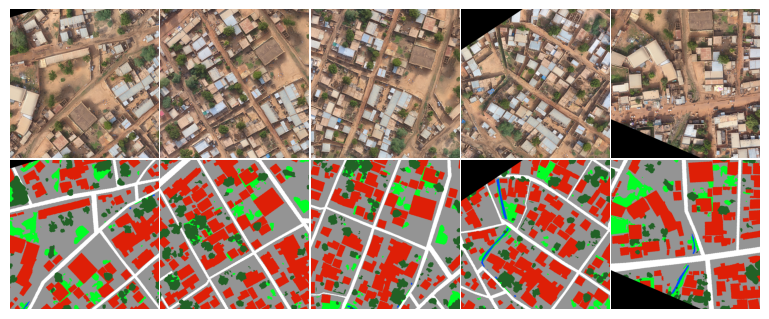

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)

    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
  
    axs[1, i].axis("off")

plt.show()

In [8]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Define the network architecture, optimizer, and criterion

In [9]:

from lovasz_losses import lovasz_softmax
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES)
# network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.MCCLoss()

### Train and validate the network

In [10]:
start = time.time()
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
max_score = 0
torch.autograd.set_detect_anomaly(True)
for epoch in range(NUM_EPOCHS):

    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_multi_loss(
        model=network,
        
        optimizer=optimizer,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_multi_loss(
        model=network,
        
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if True:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )
    
    epoch_score = train_logs["Score"]
    if train_logs["Score"]>max_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )
print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s, Loss=6.72, Score=0.166]


model saved

Epoch: 2


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, Loss=6.49, Score=0.183]


model saved

Epoch: 3


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.55it/s, Loss=6.08, Score=0.218]


model saved

Epoch: 4


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s, Loss=5.87, Score=0.241]


model saved

Epoch: 5


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s, Loss=5.62, Score=0.262]


model saved

Epoch: 6


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s, Loss=5.47, Score=0.276]


model saved

Epoch: 7


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s, Loss=5.5, Score=0.275] 


model saved

Epoch: 8


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s, Loss=5.32, Score=0.294]


model saved

Epoch: 9


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.38it/s, Loss=5.07, Score=0.317]


model saved

Epoch: 10


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s, Loss=5.07, Score=0.316]


model saved

Epoch: 11


Valid: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s, Loss=5.29, Score=0.295]


model saved

Epoch: 12


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s, Loss=4.86, Score=0.339]


model saved

Epoch: 13


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.43it/s, Loss=4.88, Score=0.335]


model saved

Epoch: 14


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s, Loss=4.79, Score=0.346]


model saved

Epoch: 15


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s, Loss=4.82, Score=0.338]


model saved

Epoch: 16


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s, Loss=4.81, Score=0.341]


model saved

Epoch: 17


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s, Loss=4.66, Score=0.358]


model saved

Epoch: 18


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s, Loss=4.62, Score=0.362]


model saved

Epoch: 19


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, Loss=4.73, Score=0.348]


model saved

Epoch: 20


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.50it/s, Loss=4.59, Score=0.363]


model saved

Epoch: 21


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s, Loss=4.61, Score=0.359]


model saved

Epoch: 22


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s, Loss=4.56, Score=0.364]


model saved

Epoch: 23


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s, Loss=4.51, Score=0.369]


model saved

Epoch: 24


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s, Loss=4.53, Score=0.368]


model saved

Epoch: 25


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s, Loss=4.37, Score=0.382]


model saved

Epoch: 26


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, Loss=4.28, Score=0.392]


model saved

Epoch: 27


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, Loss=4.4, Score=0.378] 


model saved

Epoch: 28


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s, Loss=4.58, Score=0.36] 


model saved

Epoch: 29


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, Loss=4.33, Score=0.387]


model saved

Epoch: 30


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, Loss=4.53, Score=0.362]


model saved

Epoch: 31


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s, Loss=4.35, Score=0.382]


model saved

Epoch: 32


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s, Loss=4.48, Score=0.367]


model saved

Epoch: 33


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s, Loss=4.3, Score=0.389] 


model saved

Epoch: 34


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.30it/s, Loss=4.25, Score=0.392]


model saved

Epoch: 35


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s, Loss=4.41, Score=0.378]


model saved

Epoch: 36


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s, Loss=4.42, Score=0.375]


model saved

Epoch: 37


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s, Loss=4.36, Score=0.382]


model saved

Epoch: 38


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s, Loss=4.34, Score=0.384]


model saved

Epoch: 39


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.52it/s, Loss=4.2, Score=0.397] 


model saved

Epoch: 40


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s, Loss=4.41, Score=0.373]


model saved

Epoch: 41


Valid: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s, Loss=4.44, Score=0.37] 


model saved

Epoch: 42


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s, Loss=4.21, Score=0.398]


model saved

Epoch: 43


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s, Loss=4.27, Score=0.39] 


model saved

Epoch: 44


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.44it/s, Loss=4.24, Score=0.392]


model saved

Epoch: 45


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, Loss=4.23, Score=0.393]


model saved

Epoch: 46


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s, Loss=4.26, Score=0.391]


model saved

Epoch: 47


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s, Loss=4.22, Score=0.392]


model saved

Epoch: 48


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s, Loss=4.35, Score=0.381]


model saved

Epoch: 49


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s, Loss=4.2, Score=0.395] 


model saved

Epoch: 50


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, Loss=4.26, Score=0.389]


model saved

Epoch: 51


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.98it/s, Loss=4.2, Score=0.396] 


model saved

Epoch: 52


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s, Loss=4.15, Score=0.402]


model saved

Epoch: 53


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s, Loss=4.19, Score=0.398]


model saved

Epoch: 54


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, Loss=4.21, Score=0.395]


model saved

Epoch: 55


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, Loss=4.18, Score=0.398]


model saved

Epoch: 56


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.17it/s, Loss=4.23, Score=0.393]


model saved

Epoch: 57


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s, Loss=4.18, Score=0.399]


model saved

Epoch: 58


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s, Loss=4.2, Score=0.394] 


model saved

Epoch: 59


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s, Loss=4.2, Score=0.397]


model saved

Epoch: 60


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s, Loss=4.24, Score=0.395]


model saved

Epoch: 61


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.10it/s, Loss=4.11, Score=0.404]


model saved

Epoch: 62


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, Loss=4.13, Score=0.402]


model saved

Epoch: 63


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s, Loss=4.13, Score=0.406]


model saved

Epoch: 64


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, Loss=4.13, Score=0.402]


model saved

Epoch: 65


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s, Loss=4.1, Score=0.408] 


model saved

Epoch: 66


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s, Loss=4.16, Score=0.4]  


model saved

Epoch: 67


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s, Loss=4.17, Score=0.399]


model saved

Epoch: 68


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s, Loss=4.07, Score=0.409]


model saved

Epoch: 69


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.22it/s, Loss=4.18, Score=0.397]


model saved

Epoch: 70


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.00it/s, Loss=4.23, Score=0.393]


model saved

Epoch: 71


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s, Loss=4.13, Score=0.403]


model saved

Epoch: 72


Valid: 100%|██████████| 12/12 [00:04<00:00,  3.00it/s, Loss=4.07, Score=0.409]


model saved

Epoch: 73


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, Loss=4.15, Score=0.402]


model saved

Epoch: 74


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s, Loss=4.27, Score=0.389]


model saved

Epoch: 75


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.49it/s, Loss=4.22, Score=0.392]


model saved

Epoch: 76


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.10it/s, Loss=4.09, Score=0.407]


model saved

Epoch: 77


Valid: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s, Loss=4.1, Score=0.406] 


model saved

Epoch: 78


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s, Loss=4.09, Score=0.409]


model saved

Epoch: 79


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s, Loss=4.09, Score=0.41] 


model saved

Epoch: 80


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s, Loss=4.0, Score=0.418] 


model saved

Epoch: 81


Valid: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, Loss=3.9, Score=0.427] 


model saved

Epoch: 82


Valid: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s, Loss=4.05, Score=0.411]


model saved

Epoch: 83


Train:   0%|          | 0/82 [00:00<?, ?it/s]

# Testing

### Prepare testing files

In [ ]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [ ]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, testing=True)
test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=3,
    
    num_workers=10,
    shuffle=False,
)

NameError: name 'oem' is not defined

### Load trained network

In [ ]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)
# 0.470

Loaded model:model.pth (Epoch=99, Score=0.390)


In [ ]:
test_logs = oem.runners.valid(
model=network,
criterion=criterion,
dataloader=test_data_loader,
device=DEVICE,
)

Valid:   0%|          | 0/105 [00:00<?, ?it/s]

Valid: 100%|██████████| 105/105 [00:21<00:00,  4.85it/s, Loss=0.346, Score=0.39] 


### Visualize predictions

(1024, 1024) [1 2 3 4 5 6 7 8]
(1024, 1024) [1 2 3 4 5 6 7 8]
(1024, 1024) [2 3 4 5 6 7 8]
(1024, 1024) [1 2 3 4 5 6 7 8]
(1024, 1024) [1 2 3 4 5 6 7 8]
(1024, 1024) [1 2 3 4 5 7 8]


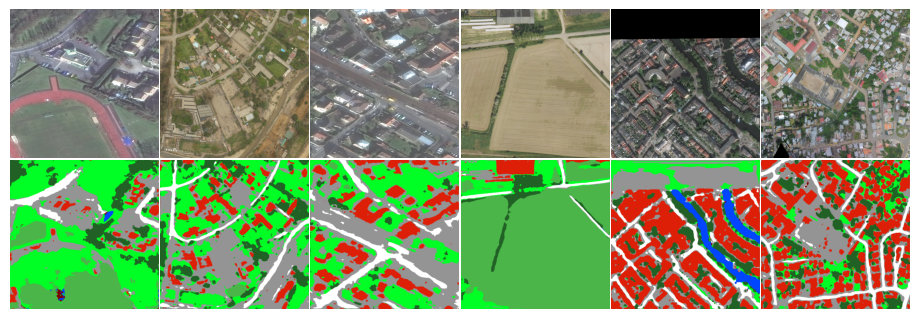

In [ ]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    
    img = np.moveaxis(img.numpy(), 0, -1)
    label = np.argmax(prd.numpy(), axis=0)
    print(label.shape, np.unique(label))
    prd = oem.utils.make_rgb(label)

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

### Save predictions in png files

In [ ]:
import math
from PIL import Image

PR_DIR = "./save_data" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input)
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)